In [1]:
import torch
from architectures import SolitonGenerator, SolitonDiscriminator
import neptune.new as neptune

In [87]:
args = {
    "n_samples": 1920,
    "n_epochs": 600,
    "device": "cpu",
    "batch_size": 32,
    "Z_dim": 10,
    "J_dim": 10,
    "hidden_dim": 256, # 256
    "gen_rnn_hidden_dim": 256,
    "gen_rnn_num_layers": 6,
    #"dis_rnn_hidden_dim": 100,
    #"dis_rnn_num_layers": 2,
    "num_hidden_layers": 5,
    "feature_dim": 120,
    "max_seq_len": 30,
    "rnn_type": "GRU",
    "use_bn": True,
    "P": 50,
    "spatial_len": 120,
    "dx": 120,
    "dt": 30,
    "t_steps": 30,
    "eta": 6.0,
    "gamma": 1.0,
}

In [88]:
from trainer import create_dataset
dataset = create_dataset("twosolitons", args["n_samples"], args, args["device"] )
dataset[:].size()

dataset: twosolitons
Loading dataset: Two Solitons
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
Concatenated data with shape (3000, 30, 120) and size: 43.2 MB


torch.Size([1920, 30, 120])

In [89]:
SolitonGenerator(args)

SolitonGenerator(
  (gen_rnn): GRU(10, 256, num_layers=5, batch_first=True)
  (gen_rnn2): GRU(256, 512, batch_first=True)
  (gen_FC): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=256, out_features=256, bias=True)
    (10): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=256, out_features=120, bias=True)
    (13): Sigmoid()
  )
)

encoder = SolitonDiscriminator(args)
encoder.to(args["device"])
decoder = SolitonGenerator(args)
decoder.to(args["device"])

z = encoder(dataset[:args["batch_size"]])
x_hat = decoder(z)
x_hat.size()


In [90]:
class Encoder(torch.nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()
        self.args = args
        self.rnn = torch.nn.GRU(
            input_size=args["dx"],
            hidden_size=args["gen_rnn_hidden_dim"],
            num_layers=1,
            batch_first=True,
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(args["gen_rnn_hidden_dim"], 256),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(256, args["Z_dim"]),
            torch.nn.Tanh() # To make sure that the values are in [-1, 1]
        )

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x)
        return x

encoder_test = Encoder(args)
encoder_test(dataset[:1]).size()

torch.Size([1, 30, 10])

In [97]:
from tqdm import trange
import matplotlib.pyplot as plt
from metrics import energy_conservation, mass_conservation, momentum_conservation

neptune_logger =  neptune.init_run(
        project="kohmann/autoencoder",
        name="autoencoder_test",
        tags=["tuning"],
        description="",
        capture_hardware_metrics=True,
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
    )

def eval(x_hat, args, neptune_logger, title="train"):
    dx = args["P"]/args["spatial_len"] # P / M
    H_error = energy_conservation(x_hat, dx=dx, eta=args["eta"], gamma=args["gamma"]).mean().item()
    H_mass_error     = mass_conservation(x_hat, dx=dx).mean().item()
    H_momentum_error = momentum_conservation(x_hat, dx=dx).mean().item()

    neptune_logger["H_mean_error_" + title].log(H_error)
    neptune_logger["H_mass_error_"  + title].log(H_mass_error)
    neptune_logger["H_momentum_error_"  + title].log(H_momentum_error)

def train(args, neptune_logger=None):
    device = args["device"]

    neptune_logger["parameters"] = args

    encoder = Encoder(args)
    decoder = SolitonGenerator(args)

    encoder.to(device)
    decoder.to(device)

    train_data = torch.utils.data.DataLoader(
            dataset=dataset[:int(args["n_samples"] * 0.8)],
            batch_size=args["batch_size"],
            shuffle=False
        )

    optimizer = torch.optim.Adam(
        list(encoder.parameters()) + list(decoder.parameters()), lr=0.001
    )
    # add scheduler that decays the learning rate every 200 epochs
    scheduler_opt = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.8)
    loss = torch.nn.MSELoss()
    train_data_test = dataset[:int(args["n_samples"] * 0.8)]
    test_data_test = dataset[int(args["n_samples"] * 0.8):]

    logger = trange(args["n_epochs"], desc=f"Epoch: 0, MSE: 0")
    for epoch in logger:
        batch_losses = 0
        for x in train_data:
            optimizer.zero_grad()
            x = x.to(device)
            z = encoder(x)
            x_hat = decoder(z)
            loss_value = loss(x_hat, x)
            loss_value.backward()
            optimizer.step()
            scheduler_opt.step()
            # print current learning rate after each 200 epoch

            batch_losses += loss_value.detach().item()
        logger.set_description(f"Epoch: {epoch}, MSE: {loss_value.item():.4f}")
        mean_loss = batch_losses / (args["n_samples"] / args["batch_size"])
        if epoch % 200 == 0:
                print('Current learning rate: ', scheduler_opt.get_lr())
        with torch.no_grad():
            z_train = encoder(train_data_test)
            fake_train = decoder(z_train).detach().cpu()
            z_test = encoder(test_data_test)
            fake_test = decoder(z_test).detach().cpu()
            mse_test = loss(fake_test, test_data_test).item()

        fig, axs = plt.subplots(3, 3, figsize=(14, 10))
        for x in range(3):
            for y in range(3):
                axs[x, y].plot(fake_test[x * 3 + y].T.cpu())
                axs[x, y].set_ylim([0, 1])

        fig.suptitle(f"Generation: {epoch}", fontsize=14)
        neptune_logger["generated_image"].log(fig)
        plt.close(fig)
        eval(fake_train, args, neptune_logger, title="train")
        eval(fake_test,  args, neptune_logger, title="test")

        neptune_logger["MSE_train"].log(mean_loss)
        neptune_logger["MSE_test"].log(mse_test)

    torch.save(encoder.state_dict(), f"./models/encoder.pt")
    torch.save(decoder.state_dict(), f"./models/decoder.pt")
    neptune_logger["model_checkpoint_encoder"].upload("./models/encoder.pt")
    neptune_logger["model_checkpoint_decoder"].upload("./models/decoder.pt")

    return encoder, decoder
encoder, decoder = train(args, neptune_logger=neptune_logger)
# uplaod model

neptune_logger.stop()

https://app.neptune.ai/kohmann/autoencoder/e/AUT-61
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Epoch: 0, MSE: 0.0155:   0%|          | 0/600 [00:06<?, ?it/s]/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Current learning rate:  [0.001]


Epoch: 118, MSE: 0.0001:  20%|█▉        | 119/600 [2:07:09<8:33:56, 64.11s/it]  


KeyboardInterrupt: 

In [ ]:
neptune_logger.stop()

In [85]:
# plot some results using the logger

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


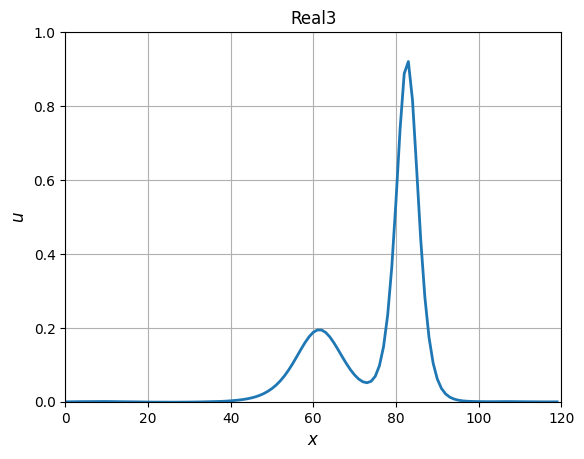

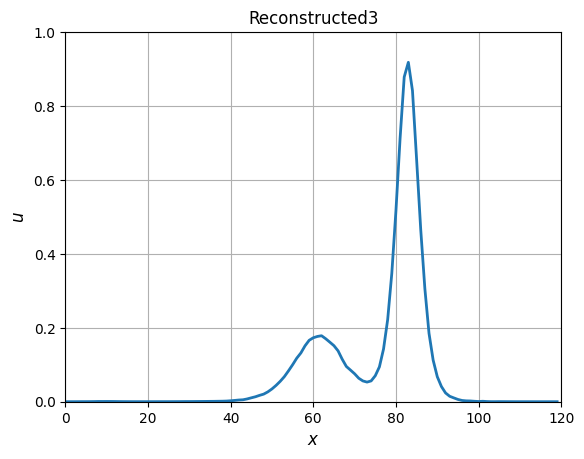

In [92]:
from matplotlib import animation, rc
import matplotlib.pyplot as plt
import numpy as np
def animate_single(data, title):
    rc('animation', html='jshtml')
    fig, ax = plt.subplots()
    line, = ax.plot([], [], lw=2)
    ax.set_xlim((0, data.shape[1]))
    ax.set_ylim((0, 1))
    ax.set_xlabel('$x$', fontsize=12)
    ax.set_ylabel('$u$', fontsize=12)
    ax.grid()
    plt.title(title)
    #x = np.arange(data.shape[1])
    x = torch.arange(data.shape[1])
    def init():
        line.set_data([], [])
        return (line,)
    def animate(i):
        line.set_data(x, data[i,:])
        return (line,)
    ani = animation.FuncAnimation(fig, animate, init_func=init,
                                  frames=data.shape[0], interval=20, blit=True)
    ani.save('plots/' + title + '.gif', fps=15)

n = 8
ani = animate_single(dataset[n].detach().numpy(), "Real3")
z = encoder(dataset[n])
x_hat = decoder(z)
ani = animate_single(x_hat.detach().numpy(), "Reconstructed3")

In [42]:
# Load best model
#torch.save(encoder.state_dict(), "models/encoder-AUT25.pt")
#torch.save(decoder.state_dict(), "models/decoder-AUT25.pt")

encoder = Encoder(args)
decoder = SolitonGenerator(args)
encoder.load_state_dict(torch.load("models/encoder_2.pt"))
decoder.load_state_dict(torch.load("models/decoder_2.pt"))
#encoder.load_state_dict(torch.load("models/encoder.pt"))

RuntimeError: Error(s) in loading state_dict for Encoder:
	Missing key(s) in state_dict: "rnn.weight_ih_l0", "rnn.weight_hh_l0", "rnn.bias_ih_l0", "rnn.bias_hh_l0", "fc.0.weight", "fc.0.bias", "fc.2.weight", "fc.2.bias", "fc.4.weight", "fc.4.bias". 
	Unexpected key(s) in state_dict: "gen_rnn.weight_ih_l0", "gen_rnn.weight_hh_l0", "gen_rnn.bias_ih_l0", "gen_rnn.bias_hh_l0", "gen_rnn2.weight_ih_l0", "gen_rnn2.weight_hh_l0", "gen_rnn2.bias_ih_l0", "gen_rnn2.bias_hh_l0", "gen_FC.0.weight", "gen_FC.0.bias", "gen_FC.2.weight", "gen_FC.2.bias", "gen_FC.4.weight", "gen_FC.4.bias", "gen_FC.6.weight", "gen_FC.6.bias", "gen_FC.8.weight", "gen_FC.8.bias". 

dataset: twosolitons
Loading dataset: Two Solitons
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
Concatenated data with shape (3000, 30, 120) and size: 43.2 MB


torch.Size([401, 30, 120])

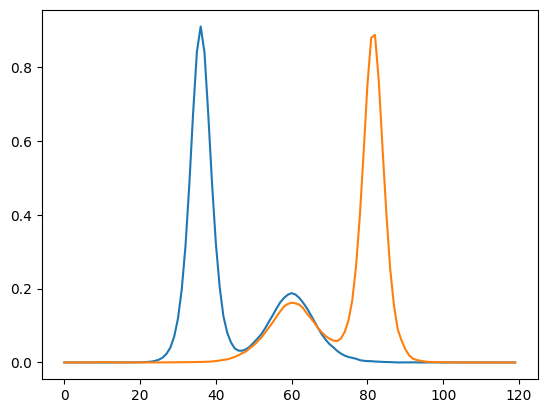

In [93]:
def does_collide(k1, k2, t=30):
    k1 = np.array(k1)
    k2 = np.array(k2)
    sol1 = 2*k1 * t + 120*0.3
    sol2 = 2*k2 * t + 120*0.5
    return sol1 > sol2

data = create_dataset("twosolitons", 3000, args, args["device"] )
encoded = encoder(data[:])
fake = decoder(encoded).detach()

fake2 = fake#model.generate(2000)
k1s = fake2[:, 0, int(120*0.3)]
k2s = fake2[:, 0, int(120*0.5)]
colliding_sample_idx = does_collide(k1s, k2s, t=30)


colliding_sampels = fake2[colliding_sample_idx==True]
non_colliding_sampels = fake2[colliding_sample_idx==False]

n = 6
plt.plot(colliding_sampels[n, 0, :])
plt.plot(colliding_sampels[n, -1, :])
colliding_sampels.shape

Mean energy error: 0.02791285328567028
Mean momentum error: 0.02930166944861412
Mean mass error: 0.037737056612968445


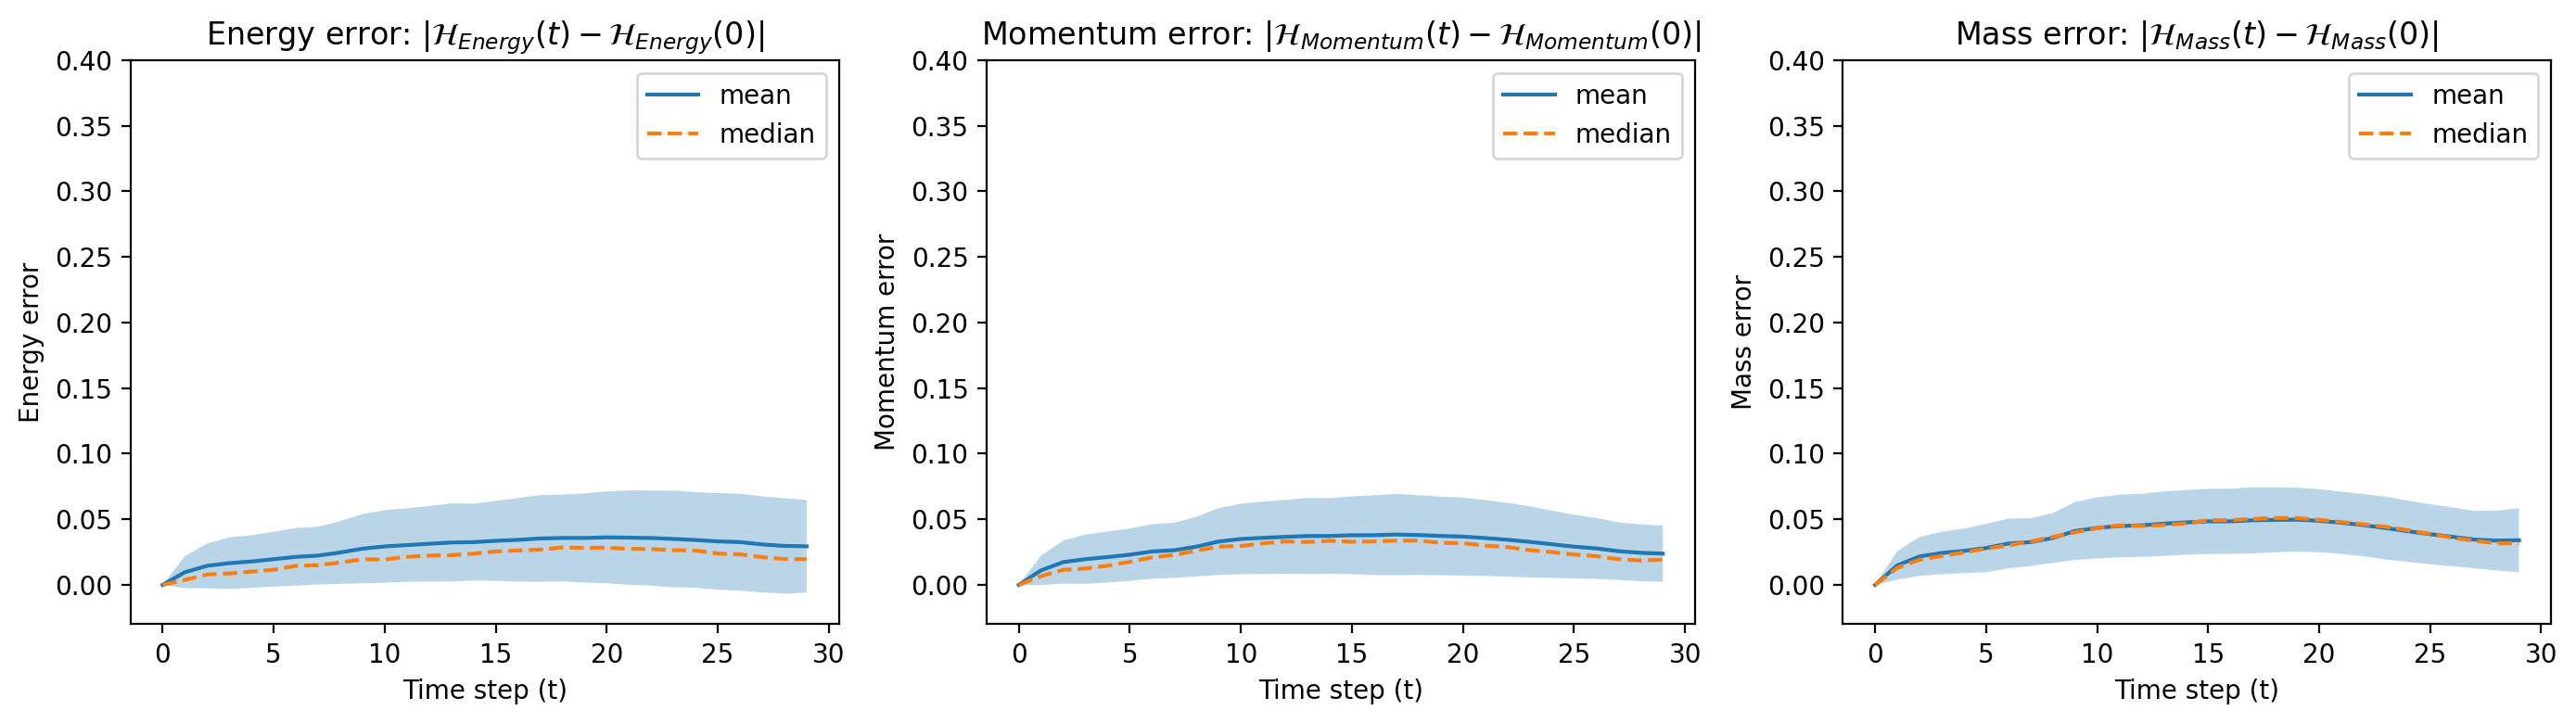

Mean energy error: 0.06994941830635071
Mean momentum error: 0.01889611780643463
Mean mass error: 0.039718352258205414


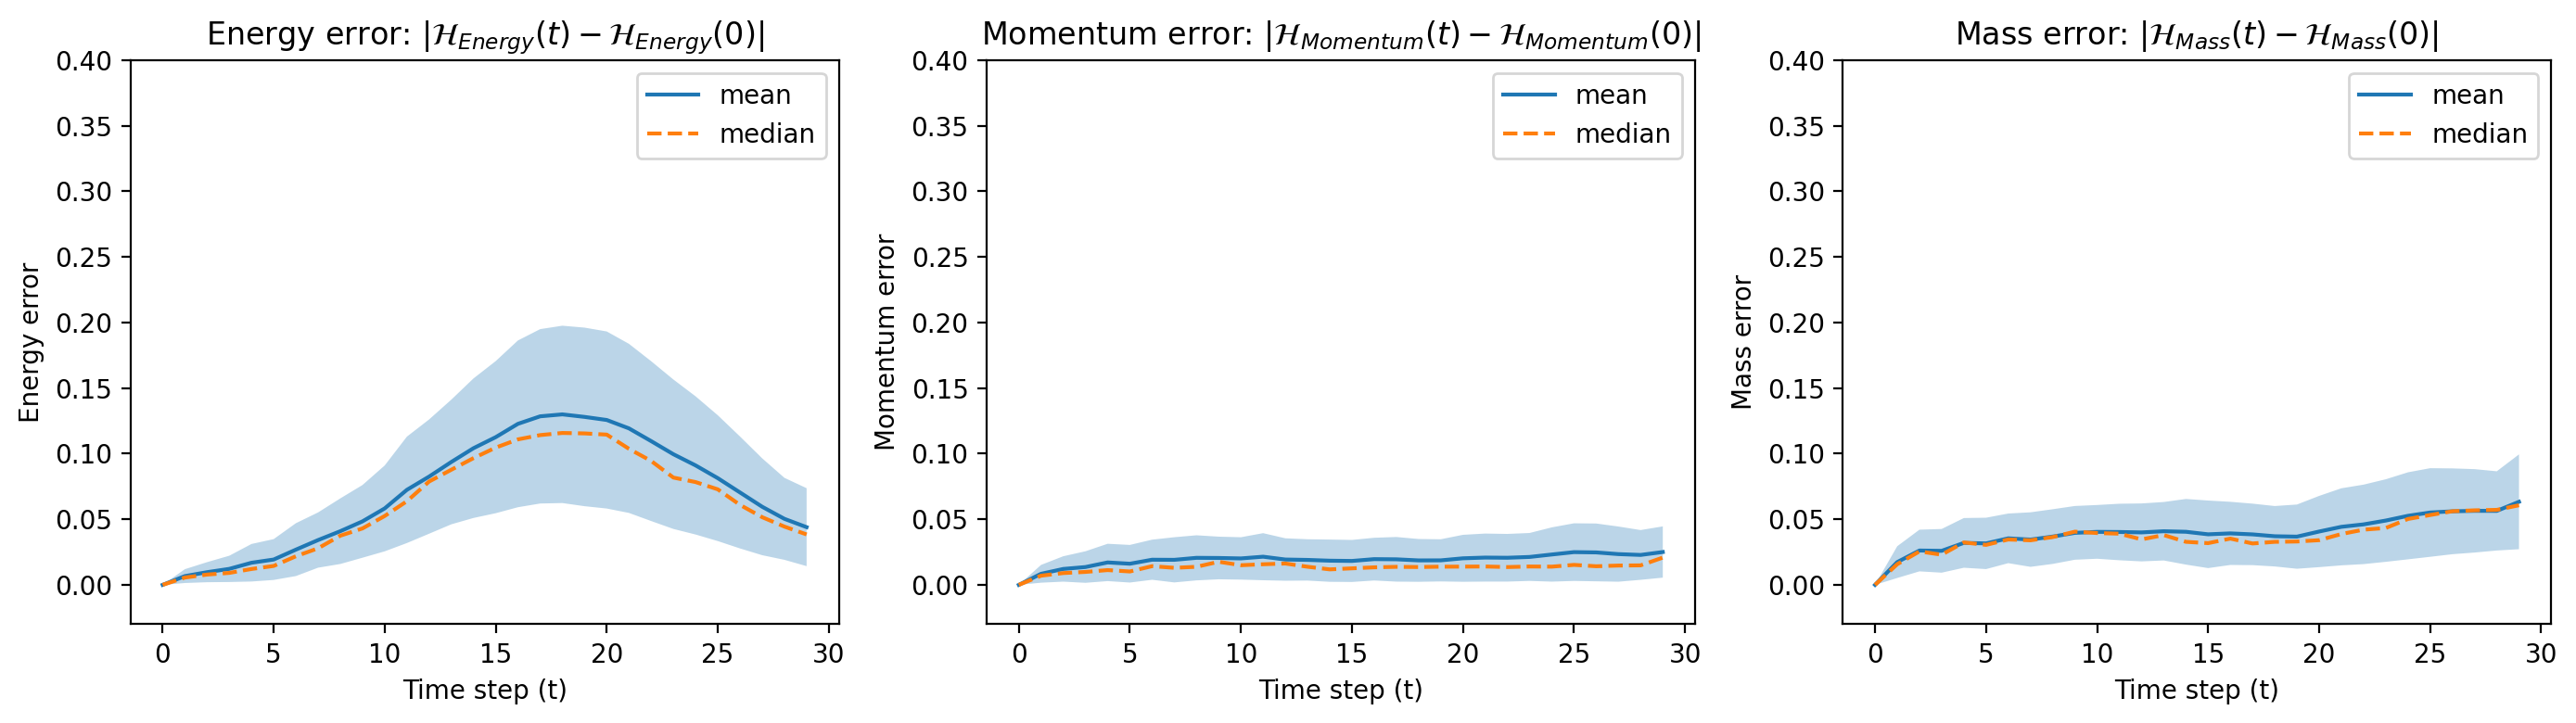

In [94]:
from metrics import energy_conservation, mass_conservation, momentum_conservation
import numpy as np
def plot_conservation_errors(data):
    H_momentum = momentum_conservation(data, dx=50/120)
    H_mass = mass_conservation(data, dx=50/120)
    H_energy = energy_conservation(data, dx=50/120, eta=6.0, gamma=0.1)

    fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=False, sharex=True, dpi=200)

    # First subplot: energy
    axs[0].plot(H_energy.mean(axis=0), label="mean")
    axs[0].plot(np.median(H_energy, axis=0), label="median", linestyle='--')
    axs[0].fill_between(np.arange(H_energy.shape[1]), H_energy.mean(axis=0) - H_energy.std(axis=0), H_energy.mean(axis=0) + H_energy.std(axis=0), alpha=0.3)
    axs[0].set_xlabel("Time step (t)")
    axs[0].set_ylabel("Energy error")
    axs[0].set_title("Energy error: $|\mathcal{{H}}_{{Energy}}(t) - \mathcal{{H}}_{{Energy}}(0)|$")
    axs[0].legend()
    print(f"Mean energy error: {H_energy.mean()}")

    # Second subplot: momentum
    axs[1].plot(H_momentum.mean(axis=0), label='mean')
    axs[1].plot(np.median(H_momentum, axis=0), label='median', linestyle='--')
    axs[1].fill_between(np.arange(H_momentum.shape[1]), H_momentum.mean(axis=0) - H_momentum.std(axis=0), H_momentum.mean(axis=0) + H_momentum.std(axis=0), alpha=0.3)
    axs[1].set_xlabel("Time step (t)")
    axs[1].set_ylabel('Momentum error')
    axs[1].set_title("Momentum error: $|\mathcal{{H}}_{{Momentum}}(t) - \mathcal{{H}}_{{Momentum}}(0)|$")
    axs[1].legend()
    print(f"Mean momentum error: {H_momentum.mean()}")

    # Third subplot: mass
    axs[2].plot(H_mass.mean(axis=0), label="mean")
    axs[2].plot(np.median(H_mass, axis=0), label="median", linestyle='--')
    axs[2].fill_between(np.arange(H_mass.shape[1]), H_mass.mean(axis=0) - H_mass.std(axis=0), H_mass.mean(axis=0) + H_mass.std(axis=0), alpha=0.3)
    axs[2].set_xlabel("Time step (t)")
    axs[2].set_ylabel('Mass error')
    axs[2].set_title("Mass error: $|\mathcal{{H}}_{{Mass}}(t) - \mathcal{{H}}_{{Mass}}(0)|$")
    axs[2].legend()

    print(f"Mean mass error: {H_mass.mean()}")
    for ax in axs:
        ax.set_ylim((-0.03, 0.40))
    plt.tight_layout()
    plt.show()

plot_conservation_errors(non_colliding_sampels)
plot_conservation_errors(colliding_sampels)

dataset: twosolitons
Loading dataset: Two Solitons
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
RAW data: (1000, 360, 360), MB: 518.4
	Downsampled:(1000, 30, 120), MB: 14.4
Concatenated data with shape (3000, 30, 120) and size: 43.2 MB


torch.Size([417, 30, 120])

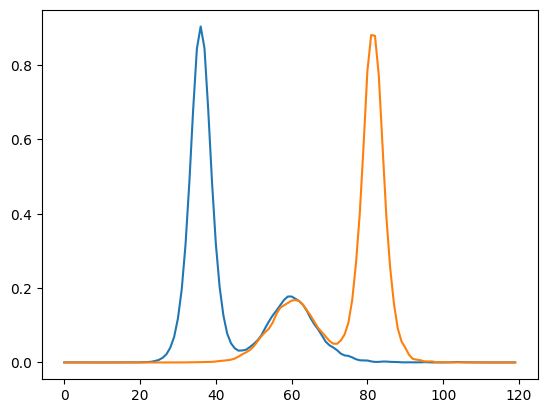